In [1]:
import imp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
import sys
def flushPrint(s):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % s)
    sys.stdout.flush()

In [2]:
#导入一系列nltk相关的包
import nltk
#nltk.download('stopwords') 第一次运行时报错提示下载
from nltk import pos_tag # part of speech tagging
from nltk.corpus import stopwords  #停词 如and, yet, he she 等
from nltk.tokenize import sent_tokenize 
from nltk.corpus import wordnet as wn #wordnet
stop = set(stopwords.words('english'))
stop.add('wo')
stop.add("n't")
from nltk.stem.wordnet import WordNetLemmatizer #进行词形还原，如还原复数形式，is,are改成be.
from nltk.util import ngrams
wnl = WordNetLemmatizer()

from gensim.models import Phrases
from gensim.corpora import Dictionary

# Load data

In [3]:
path = '../Input_data/'
versions = ['v2.0', 'v2.1', 'v2.2', 'v3', 'v4.0', 'v4.1']

In [4]:
data_original = []
for v in versions:
    file = v+'.txt'
    f = open(path+file, encoding="utf-8")
    content = f.read()

    content = content.replace('\nn ', '\n')

    credits = content.split('\n\n')
    for i in range(len(credits)):
        pcs = credits[i].split('\n')
        id = pcs[0]
        dsp = ''
        for j in range(1, len(pcs)):
            dsp += pcs[j] + ' '
    
        data_original.append([v, id, dsp])

data = pd.DataFrame(data_original, columns=["Version", "ID", "Content"])

# Lemmatize

In [5]:
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def is_roman_number(num):

    pattern = re.compile(r"""   
                                ^M{0,3}
                                (CM|CD|D?C{0,3})?
                                (XC|XL|L?X{0,3})?
                                (IX|IV|V?I{0,3})?$
            """, re.VERBOSE)

    if re.match(pattern, num):
        return True
    return False
    
def lemmatize_sent(text,exclude_stopwords=False,exclude_romannumbers=False): 
    # Text input is string, returns lowercased strings.
    temp = []
    for word, tag in pos_tag(nltk.word_tokenize(text)):

        include=True
        if exclude_stopwords:
            if word.lower() in stop:
                include=False

        if exclude_romannumbers:
            if is_roman_number(word.upper()):
                include=False
        
        if word.isalpha() and include:
            if tag=="IN":
                temp.append([word.lower(),tag])
            else:
                temp.append([wnl.lemmatize(word.lower(), pos=penn2morphy(tag)),tag])
    return temp

In [6]:
lemmatize = []
tokens = []
for i in data.index:
    lem = lemmatize_sent(data['Content'][i], exclude_stopwords=True, exclude_romannumbers=True)
    lemmatize.append(lem)
    tok = [lem[j][0] for j in range(len(lem))]
    tokens.append(tok)
    
    msg = 'Lemmatizing for ' + str(i+1) + ' in ' + str(len(data))
    flushPrint(msg)

data['Lemmatize'] = lemmatize
data['Tokens'] = tokens

Lemmatizing for 280 in 280

# Filter

In [7]:
PP = data['Tokens'].tolist()

bigram = Phrases(PP, min_count=25) # 补充ngrams,要求最少出现过min_count次

for idx in range(len(PP)):#iterate over all items
    s = 'Iterating for ' + str(idx+1) + ' in ' + str(len(PP))
    flushPrint(s)
    for token in bigram[PP[idx]]:#iterate over all tokens
        if '_' in token:# if Token is a newly created bigram, add to document.
            PP[idx].append(token)

data['Tokens_bigtam']=PP

Iterating for 280 in 280

In [8]:
# Remove rare and common tokens.

# Create a dictionary representation of the documents.
dictionary = Dictionary(PP)

# Filter out words that occur less than (n=no_below) docs, or more than (no_above) of the documents.
dictionary.filter_extremes(no_below=1, no_above=0.2)

In [9]:
data_filtered = []
for row in PP:
    temp = []
    for token in row:
        if token in dictionary.token2id:
            temp.append(token)
    data_filtered.append(temp)

data['Tokens_filtered'] = data_filtered

In [10]:
# Get corpus: a Bag-of-words representation of the documents -- each item :  [word_id, frequency]
corpus = [dictionary.doc2bow(doc) for doc in data_filtered]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

data['BOW'] = corpus

Number of unique tokens: 3038
Number of documents: 280


# TF-IDF vectors

$$
{\rm IDF}_{\cal w} = \log{ \frac{N_{all}}{N_{\cal w}+1} },
$$
where $N_{all}$ is the number of all documents, and $N_{\cal w}$ is the number of documents containing word $\cal w$.

$$
{\rm TF}_i = \frac{L_{{\cal w}, i}}{L_{all, i}},
$$
where $L_{{\cal w}, i}$ is the number of word $\cal w$ in document $i$, and $L_{all, i}$ is the number of all words in document $i$.

The TF-IDF vector of a document is defined on a high-dimensional space composed of all unique words (tokens). The element in the IDF-TF vector representing word $\cal w$ is defined as
$$
\begin{aligned}
{\rm TF\_IDF}_{\cal w} &= \rm TF\cdot IDF\\
&= \frac{L_{{\cal w}, i}}{L_{all, i}} \cdot \log{ \frac{N_{all}}{N_{\cal w}+1} }
\end{aligned}
$$


If a word is commonly used, then its $\rm IDF$ will be very small (close to zero). Therefore, even if that word takes up a big proportion in one document, its element in the TF-IDF vector will still be small.

In [11]:
doc_num = len(data)
IDF = {}
for wi in dictionary.keys():
    word = dictionary[wi]
    count = 0
    for i in data.index:
        if word in data['Tokens_filtered'][i]:
            count += 1
    IDF[wi] = np.log( doc_num / (count+1) )

In [12]:
TF_IDFs = []
for i in data.index:
    TF_IDFi = len(dictionary)*[0]
    ALLi = len(data['Tokens_filtered'][i])
    for wj in data['BOW'][i]:
        wj_key = wj[0]
        wj_num = wj[1]
        TF_IDFi[wj_key] = wj_num/ALLi * IDF[wj_key]
    TF_IDFs.append(TF_IDFi)
    
data['TF_IDF'] = TF_IDFs

# Cosine similarity

In [13]:
# compare v2.1 and v2.0 as example
mtr_dfs = {}
for i in range(len(versions)-1):
    v1 = versions[i]
    v2 = versions[i+1]
    l1 = len(data[data['Version']==v1])
    l2 = len(data[data['Version']==v2])

    mtr = []
    for i in range(l1):
        m = []
        vec1 = data[data['Version']==v1]['TF_IDF'].tolist()[i]
        id1 = data[data['Version']==v1]['ID'].tolist()[i]
        for j in range(l2):
            flushPrint('Calculating cosine similarity of '+v1+' to '+v2+': '+str(i*l2+j+1)+'/'+str(l1*l2)+'          ')
            vec2 = data[data['Version']==v2]['TF_IDF'].tolist()[j]
            id2 = data[data['Version']==v2]['ID'].tolist()[j]
            if id1.split('-')[0]!=id2.split('-')[0]:
                m.append(0)
                continue
            a, b, c = 0, 0, 0
            for k in range(len(dictionary)):
                a += vec1[k] * vec2[k]
                b += np.power(vec1[k], 2)
                c += np.power(vec2[k], 2)
            b, c = np.sqrt(b), np.sqrt(c)
            d = a / (b*c)
            m.append(d)
        mtr.append(m)

    mtr_df = pd.DataFrame(
        mtr,
        index=data[data['Version']==v1]['ID'].tolist(),
        columns=data[data['Version']==v2]['ID'].tolist()
    )
    mtr_dfs[v1+' to '+v2] = mtr_df

    # fig, ax = plt.subplots(figsize=(20,15))

    # ax = sns.heatmap(
    #     mtr_df,
    #     cmap='inferno', vmax=1, vmin=0,
    #     square=False,
    #     xticklabels=True, yticklabels=True,
    #     linewidths=1, linecolor='k'
    # )
    # plt.title('Transition matrix: '+str(v1)+' to '+str(v2), fontsize=20) #, fontsize=20)
    # plt.xlabel(v2, fontsize=16)
    # plt.ylabel(v1, fontsize=16)

    # plt.tight_layout()
    # plt.savefig('../output/Transition_matrix_'+str(v1)+'to'+str(v2)+'.jpg',dpi=300)

    # plt.show()

Calculating cosine similarity of v4.0 to v4.1: 1806/1806          

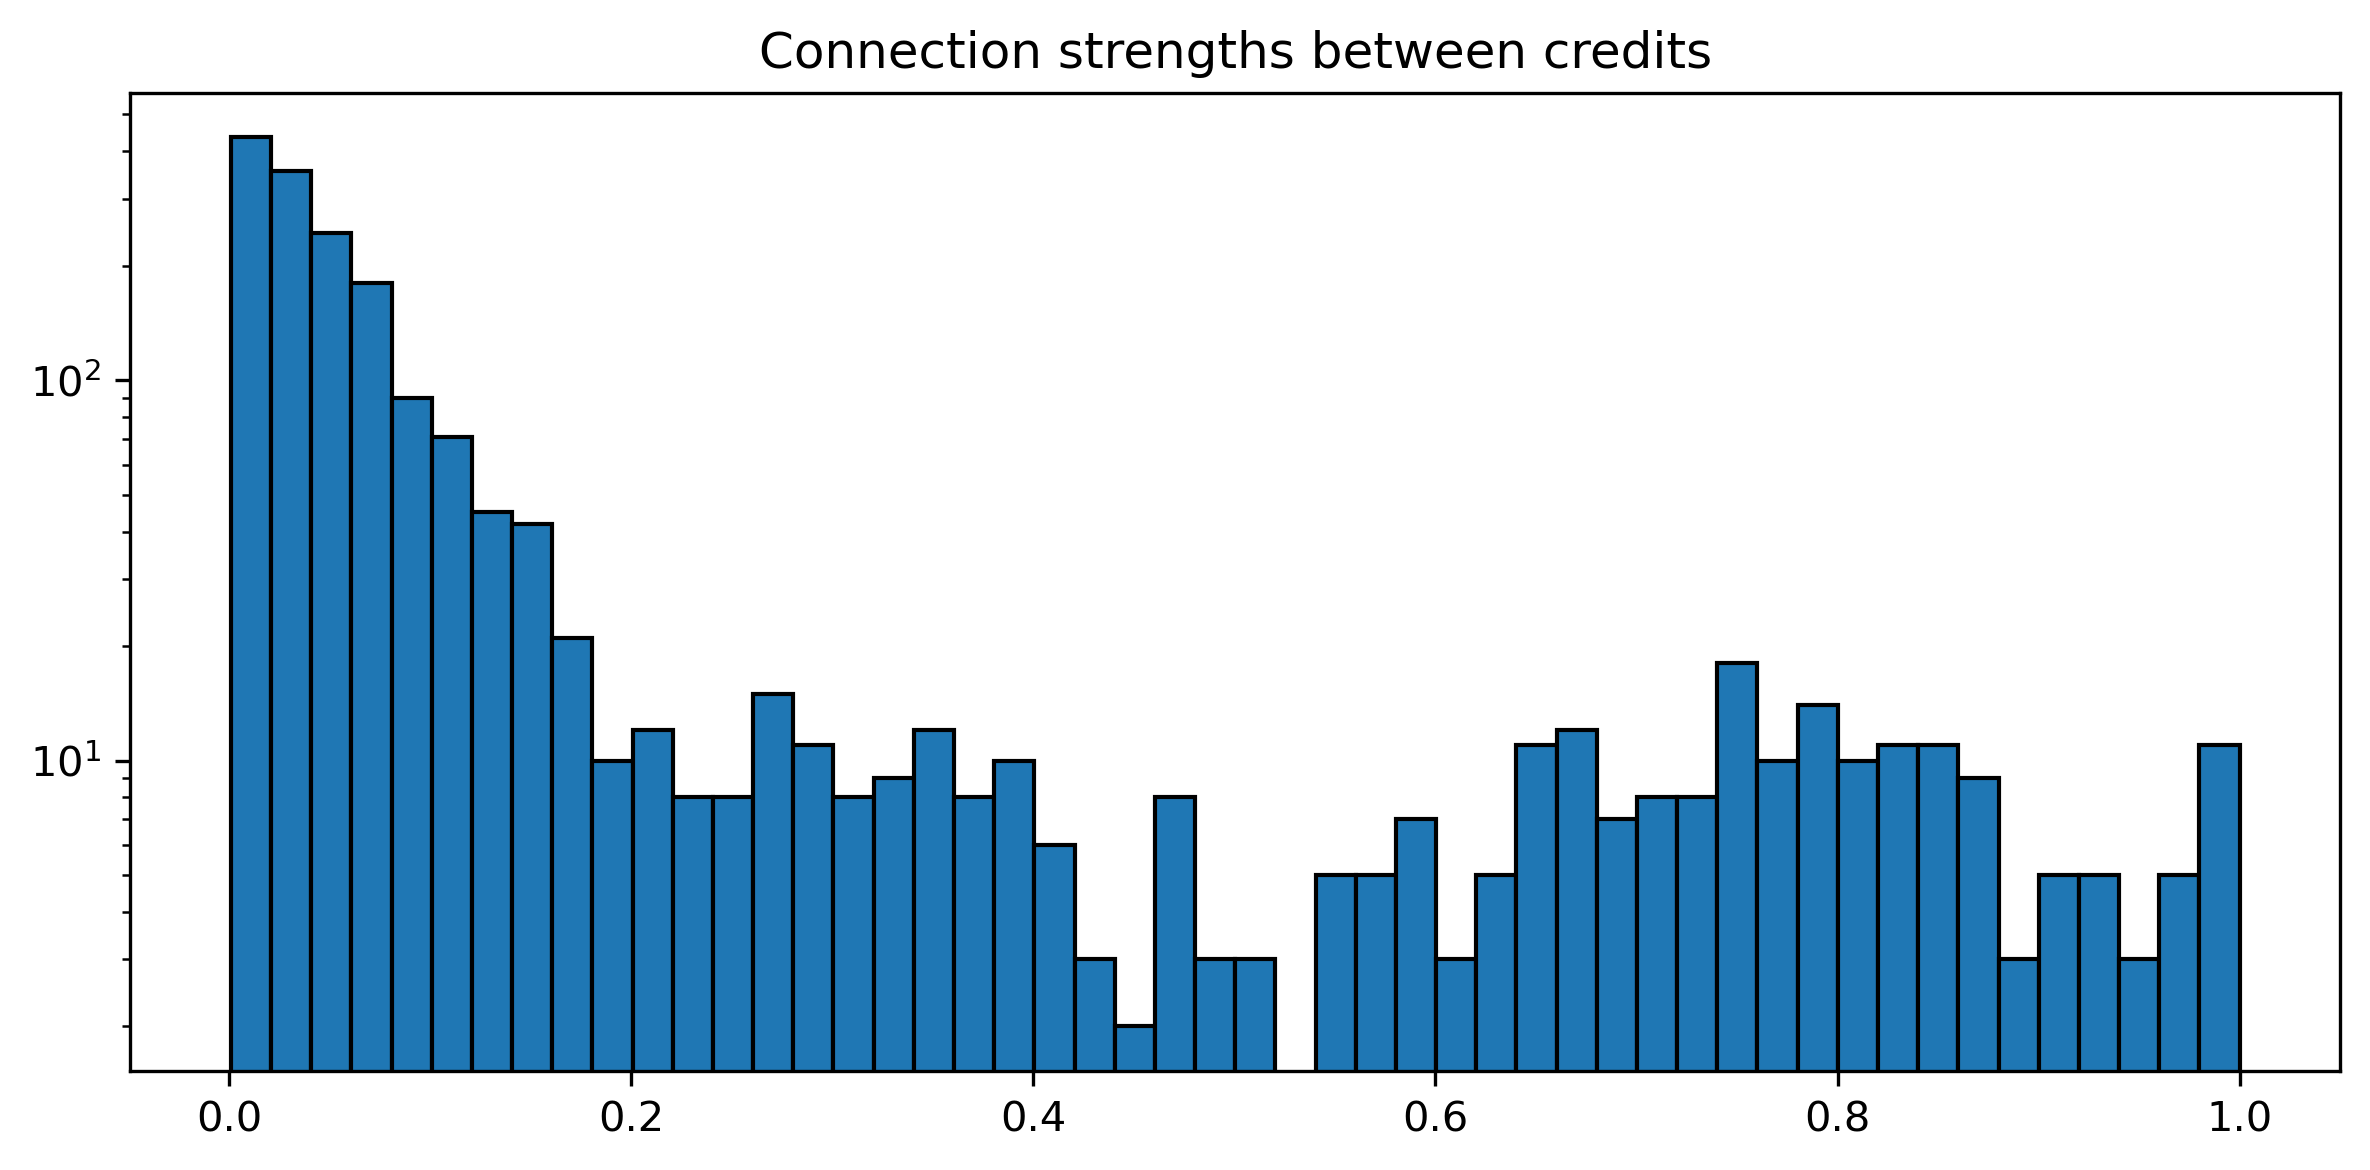

In [14]:
ms = []
for link in mtr_dfs.keys():
    m = mtr_dfs[link]
    for i in m.index:
        for j in m.columns:
            if m.loc[i, j]>0:
                ms.append(m.loc[i, j])

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
ax = plt.hist(
    ms,
    bins=50, histtype='bar', edgecolor='k'
)
plt.yscale('log')#,nonposy='mask',subsy=[0])
# plt.plot([0.2, 0.2], [0, 400], 'r', linestyle='--')
plt.title('Connection strengths between credits')
# plt.text(0.21, 200, 'threshold=0.20', color='r')
plt.tight_layout()

plt.savefig('../Outputs/Histogram.jpg')

plt.show()

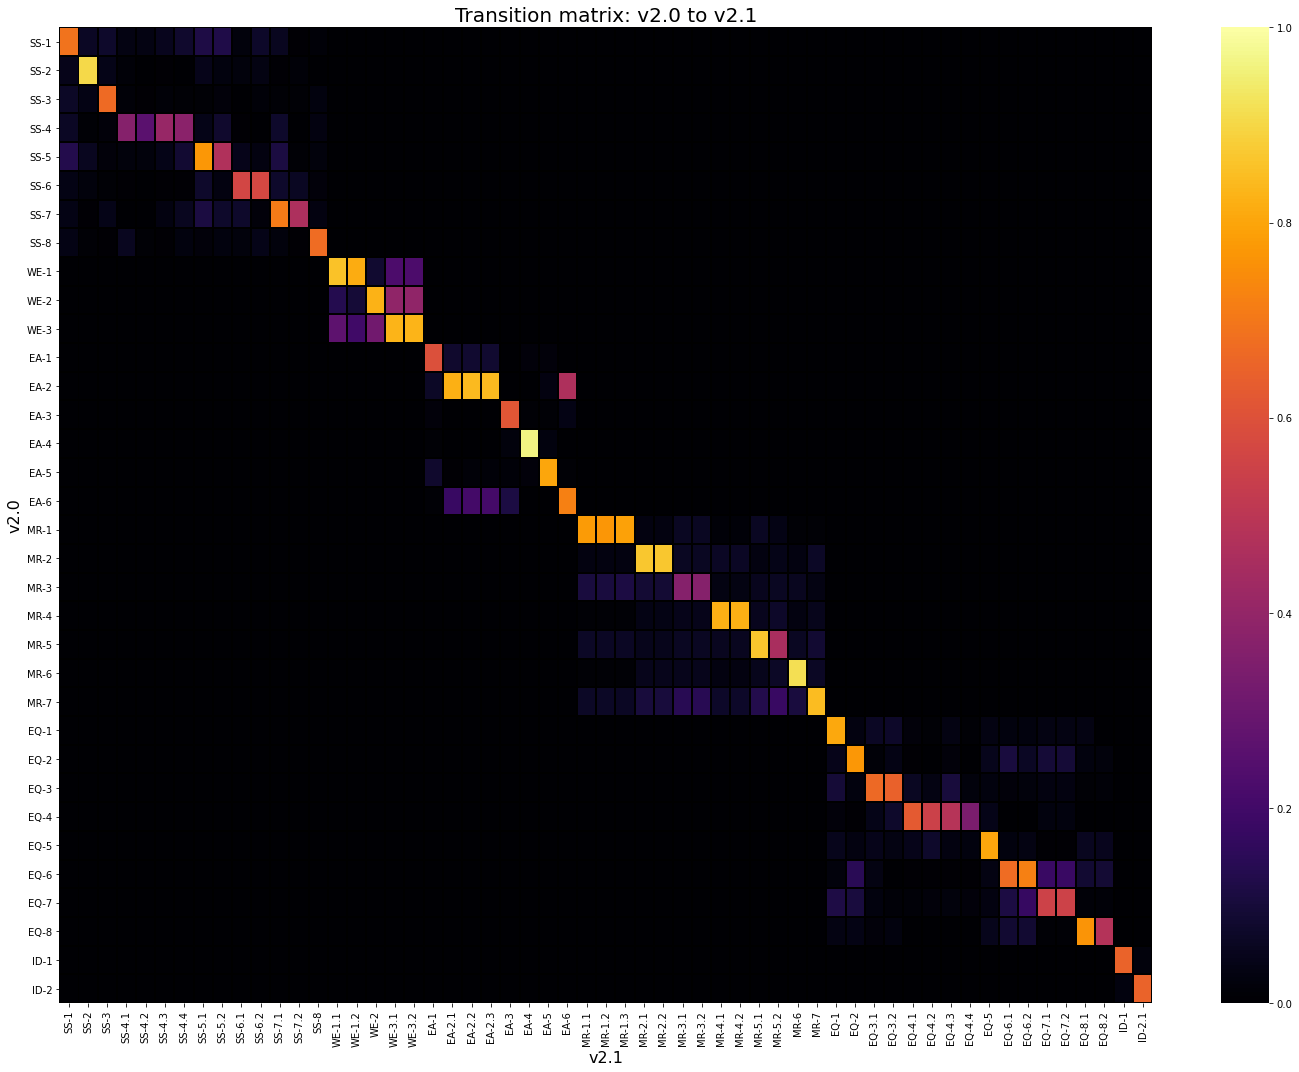

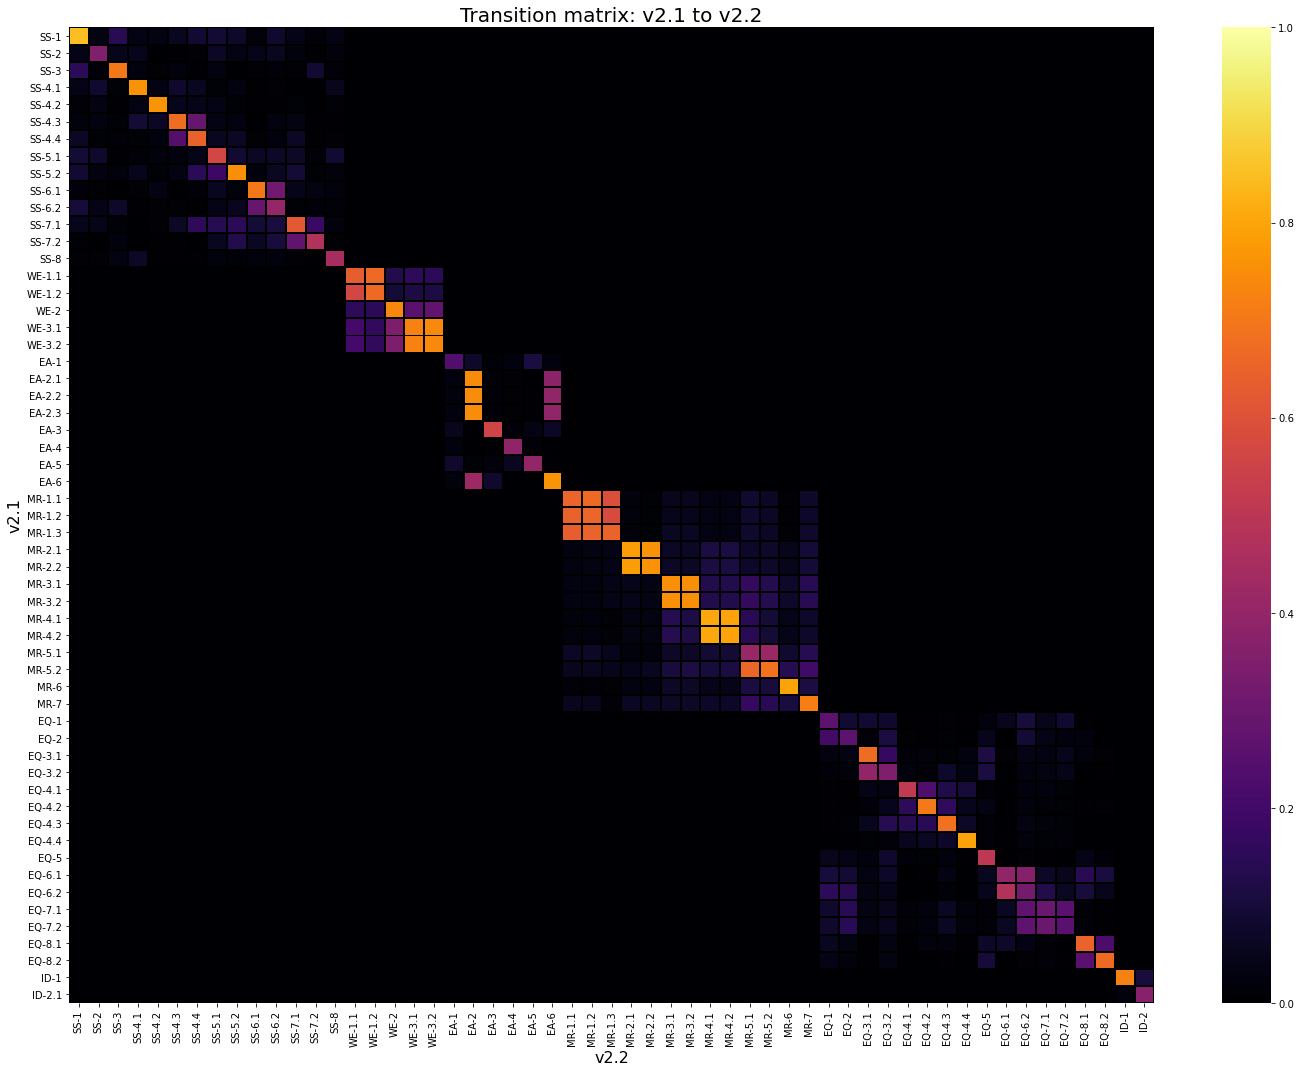

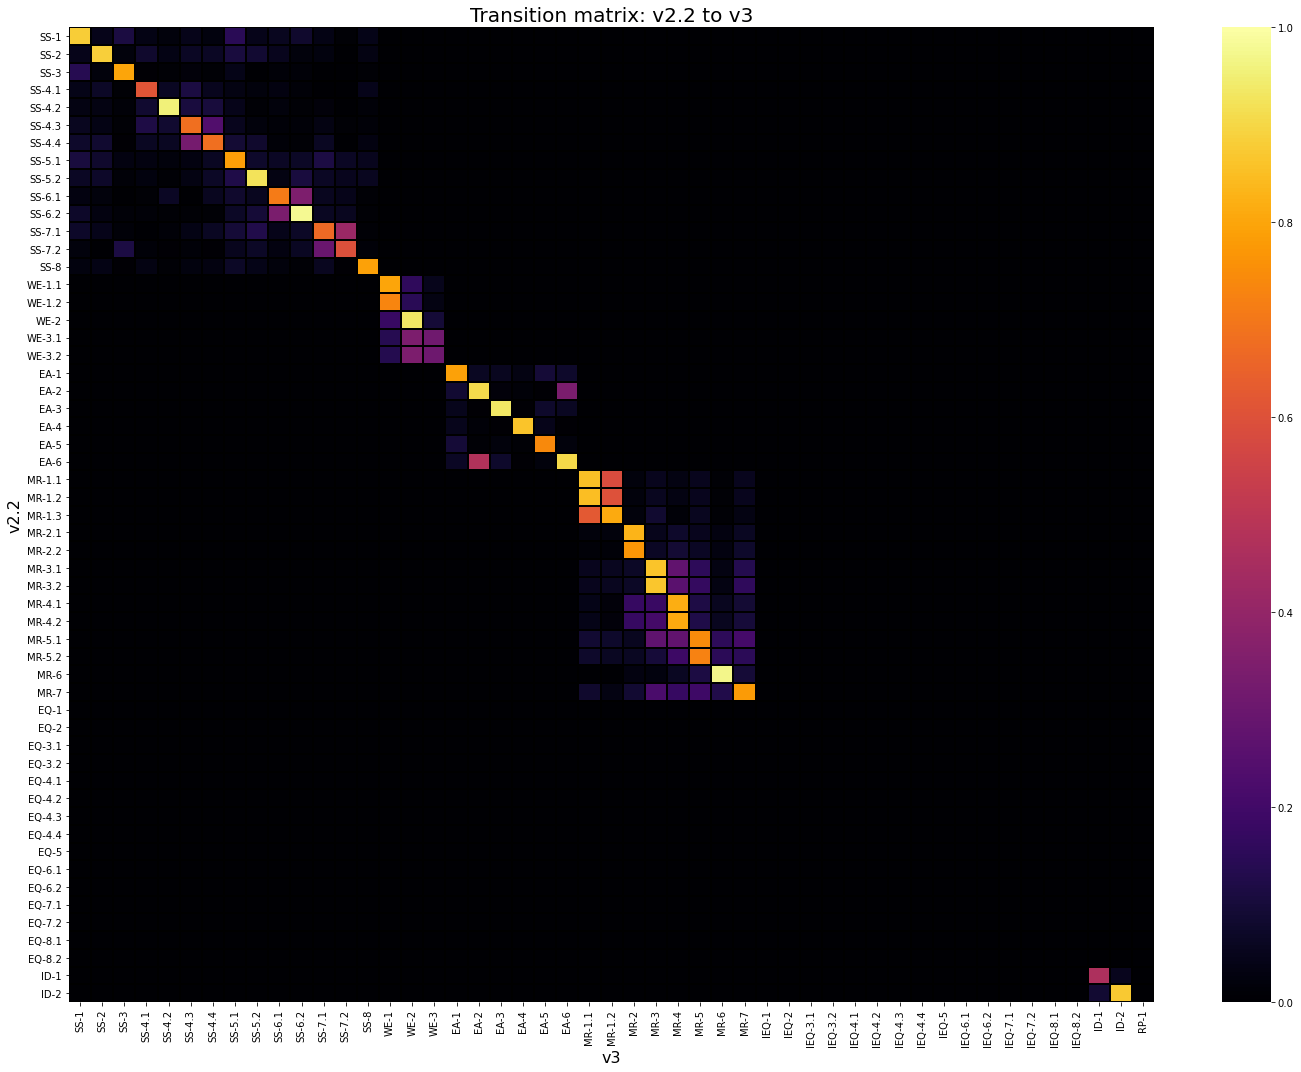

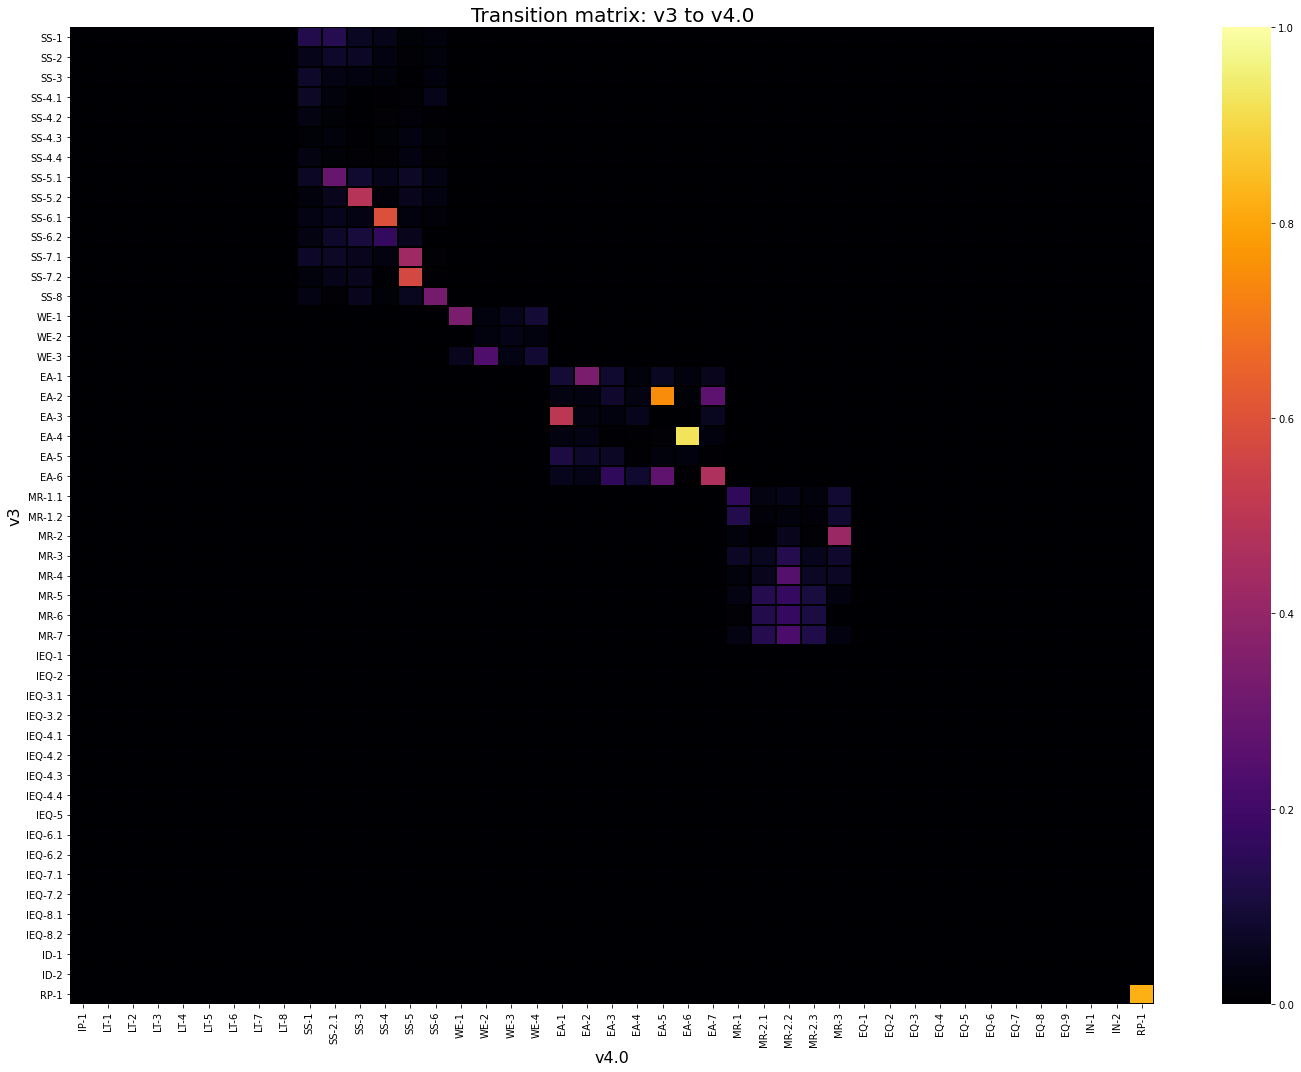

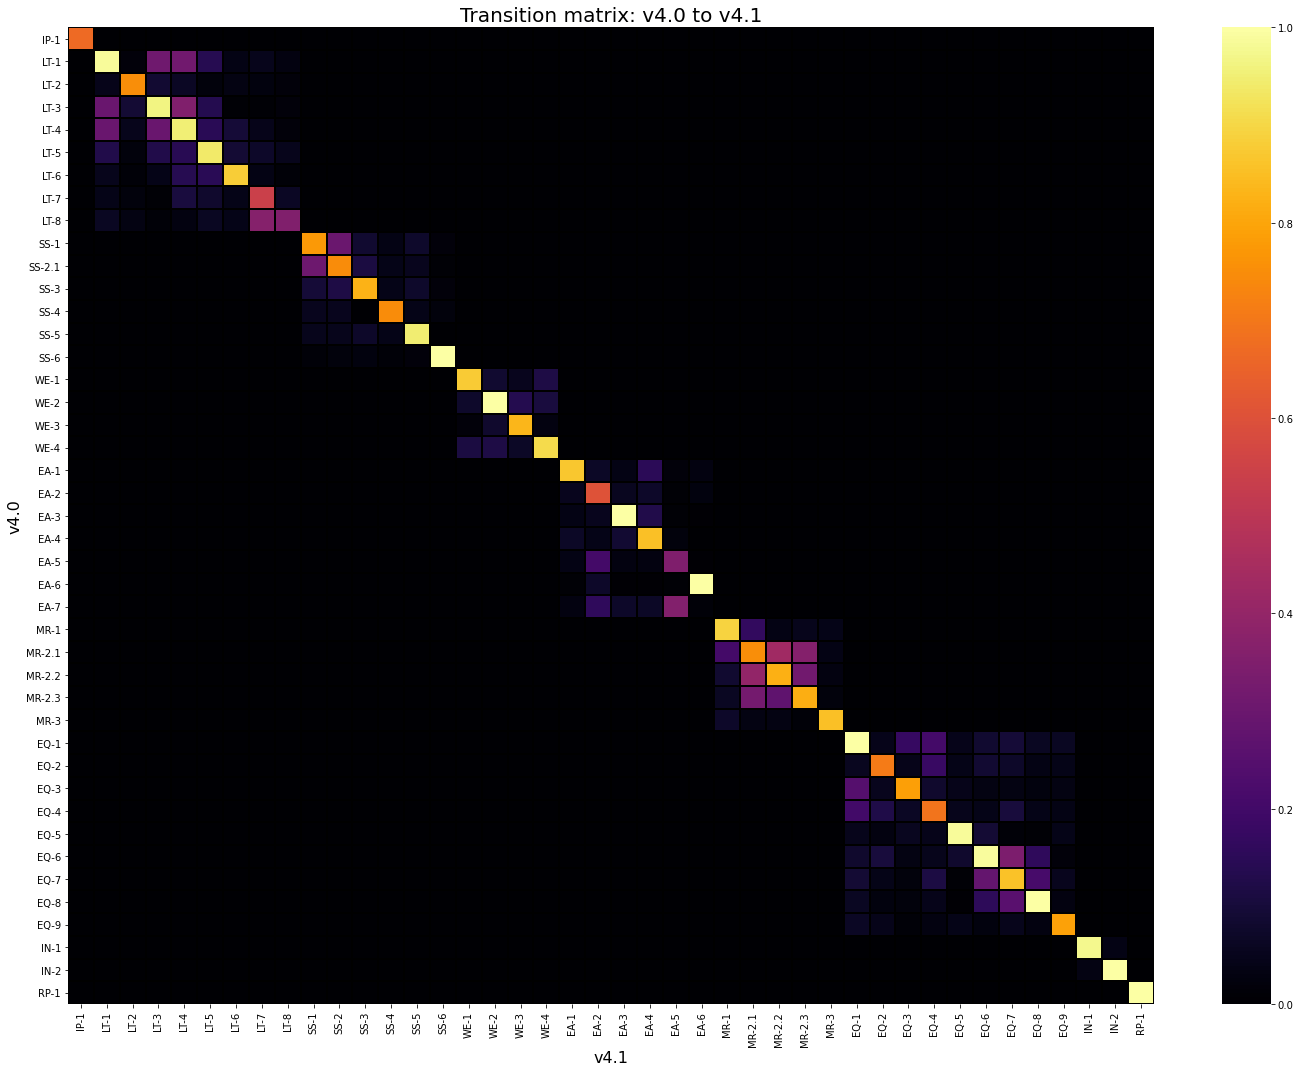

In [15]:
for i in range(len(versions)-1):
    v1 = versions[i]
    v2 = versions[i+1]
    l1 = len(data[data['Version']==v1])
    l2 = len(data[data['Version']==v2])

    fig, ax = plt.subplots(figsize=(20,15))

    ax = sns.heatmap(
        mtr_dfs[v1+' to '+v2],
        cmap='inferno', vmax=1, vmin=0,
        square=False,
        xticklabels=True, yticklabels=True,
        linewidths=1, linecolor='k'
    )
    plt.title('Transition matrix: '+str(v1)+' to '+str(v2), fontsize=20) #, fontsize=20)
    plt.xlabel(v2, fontsize=16)
    plt.ylabel(v1, fontsize=16)

    plt.tight_layout()
    plt.savefig('../Outputs/Transition_matrix_'+str(v1)+'to'+str(v2)+'.jpg',dpi=300)

    plt.show()

In [16]:
data.to_pickle('../Outputs/data.pkl')
pd.to_pickle(mtr_dfs, '../Outputs/mtr_dfs.pkl')

# Credit flow network

In [17]:
data = pd.read_pickle('../Outputs/data.pkl')
mtr_dfs = pd.read_pickle('../Outputs/mtr_dfs.pkl')

In [18]:
def get_color(s):
    a = len(s)
    np.random.seed(a**2)
    if 'Energy' in s:
        np.random.seed(43259)
    elif 'Materials' in s:
        np.random.seed(593)
    elif 'Innovation' in s:
        np.random.seed(6953)
    return [np.random.rand()**0.5, np.random.rand()**0.5, np.random.rand()**0.5]

In [19]:
versions = ['v2.0', 'v2.1', 'v2.2', 'v3', 'v4.0', 'v4.1']
df = []
for i in range(6):
    v = versions[i]
    credits = pd.read_excel('../Input_data/LEED_credits.xlsx', sheet_name=v, header=1)
    ver = pd.read_excel('../Input_data/LEED_credits.xlsx', sheet_name=v, nrows=0).columns[0]
    title = pd.read_excel('../Input_data/LEED_credits.xlsx', sheet_name=v, nrows=0).columns[1]
    year = pd.read_excel('../Input_data/LEED_credits.xlsx', sheet_name=v, nrows=0).columns[2]
    total_pts = pd.read_excel('../Input_data/LEED_credits.xlsx', sheet_name=v, nrows=0).columns[3]
    f = {
        'ver': ver,
        'title': title,
        'year': year,
        'cred': credits,
        'total': total_pts
    }
    df.append(f)

In [20]:
def get_Ypos(cred):
    expand = 100
    total_p = np.sum([np.sqrt(p) for p in cred['Points'].to_list()])
    zoom = expand/total_p
    Ypos = []
    for i in cred.index:
        if i==0:
            Y = np.sqrt(cred['Points'][i])*zoom/2
        else:
            Y = Ypos[-1] + np.sqrt(cred['Points'][i])*zoom/2 + np.sqrt(cred['Points'][i-1])*zoom/2
        Ypos.append(Y)
    return Ypos

In [21]:
def get_connection(f1, f2, j1, j2):
    v1, v2 = f1['ver'], f2['ver']
    link = v1 + ' to ' + v2
    m = mtr_dfs[link]

    # from j1,j2 to id1,id2
    id1 = data[data['Version']==v1]['ID'].to_list()[j1]
    id2 = data[data['Version']==v2]['ID'].to_list()[j2]

    connection = m.loc[id1, id2]
    return connection

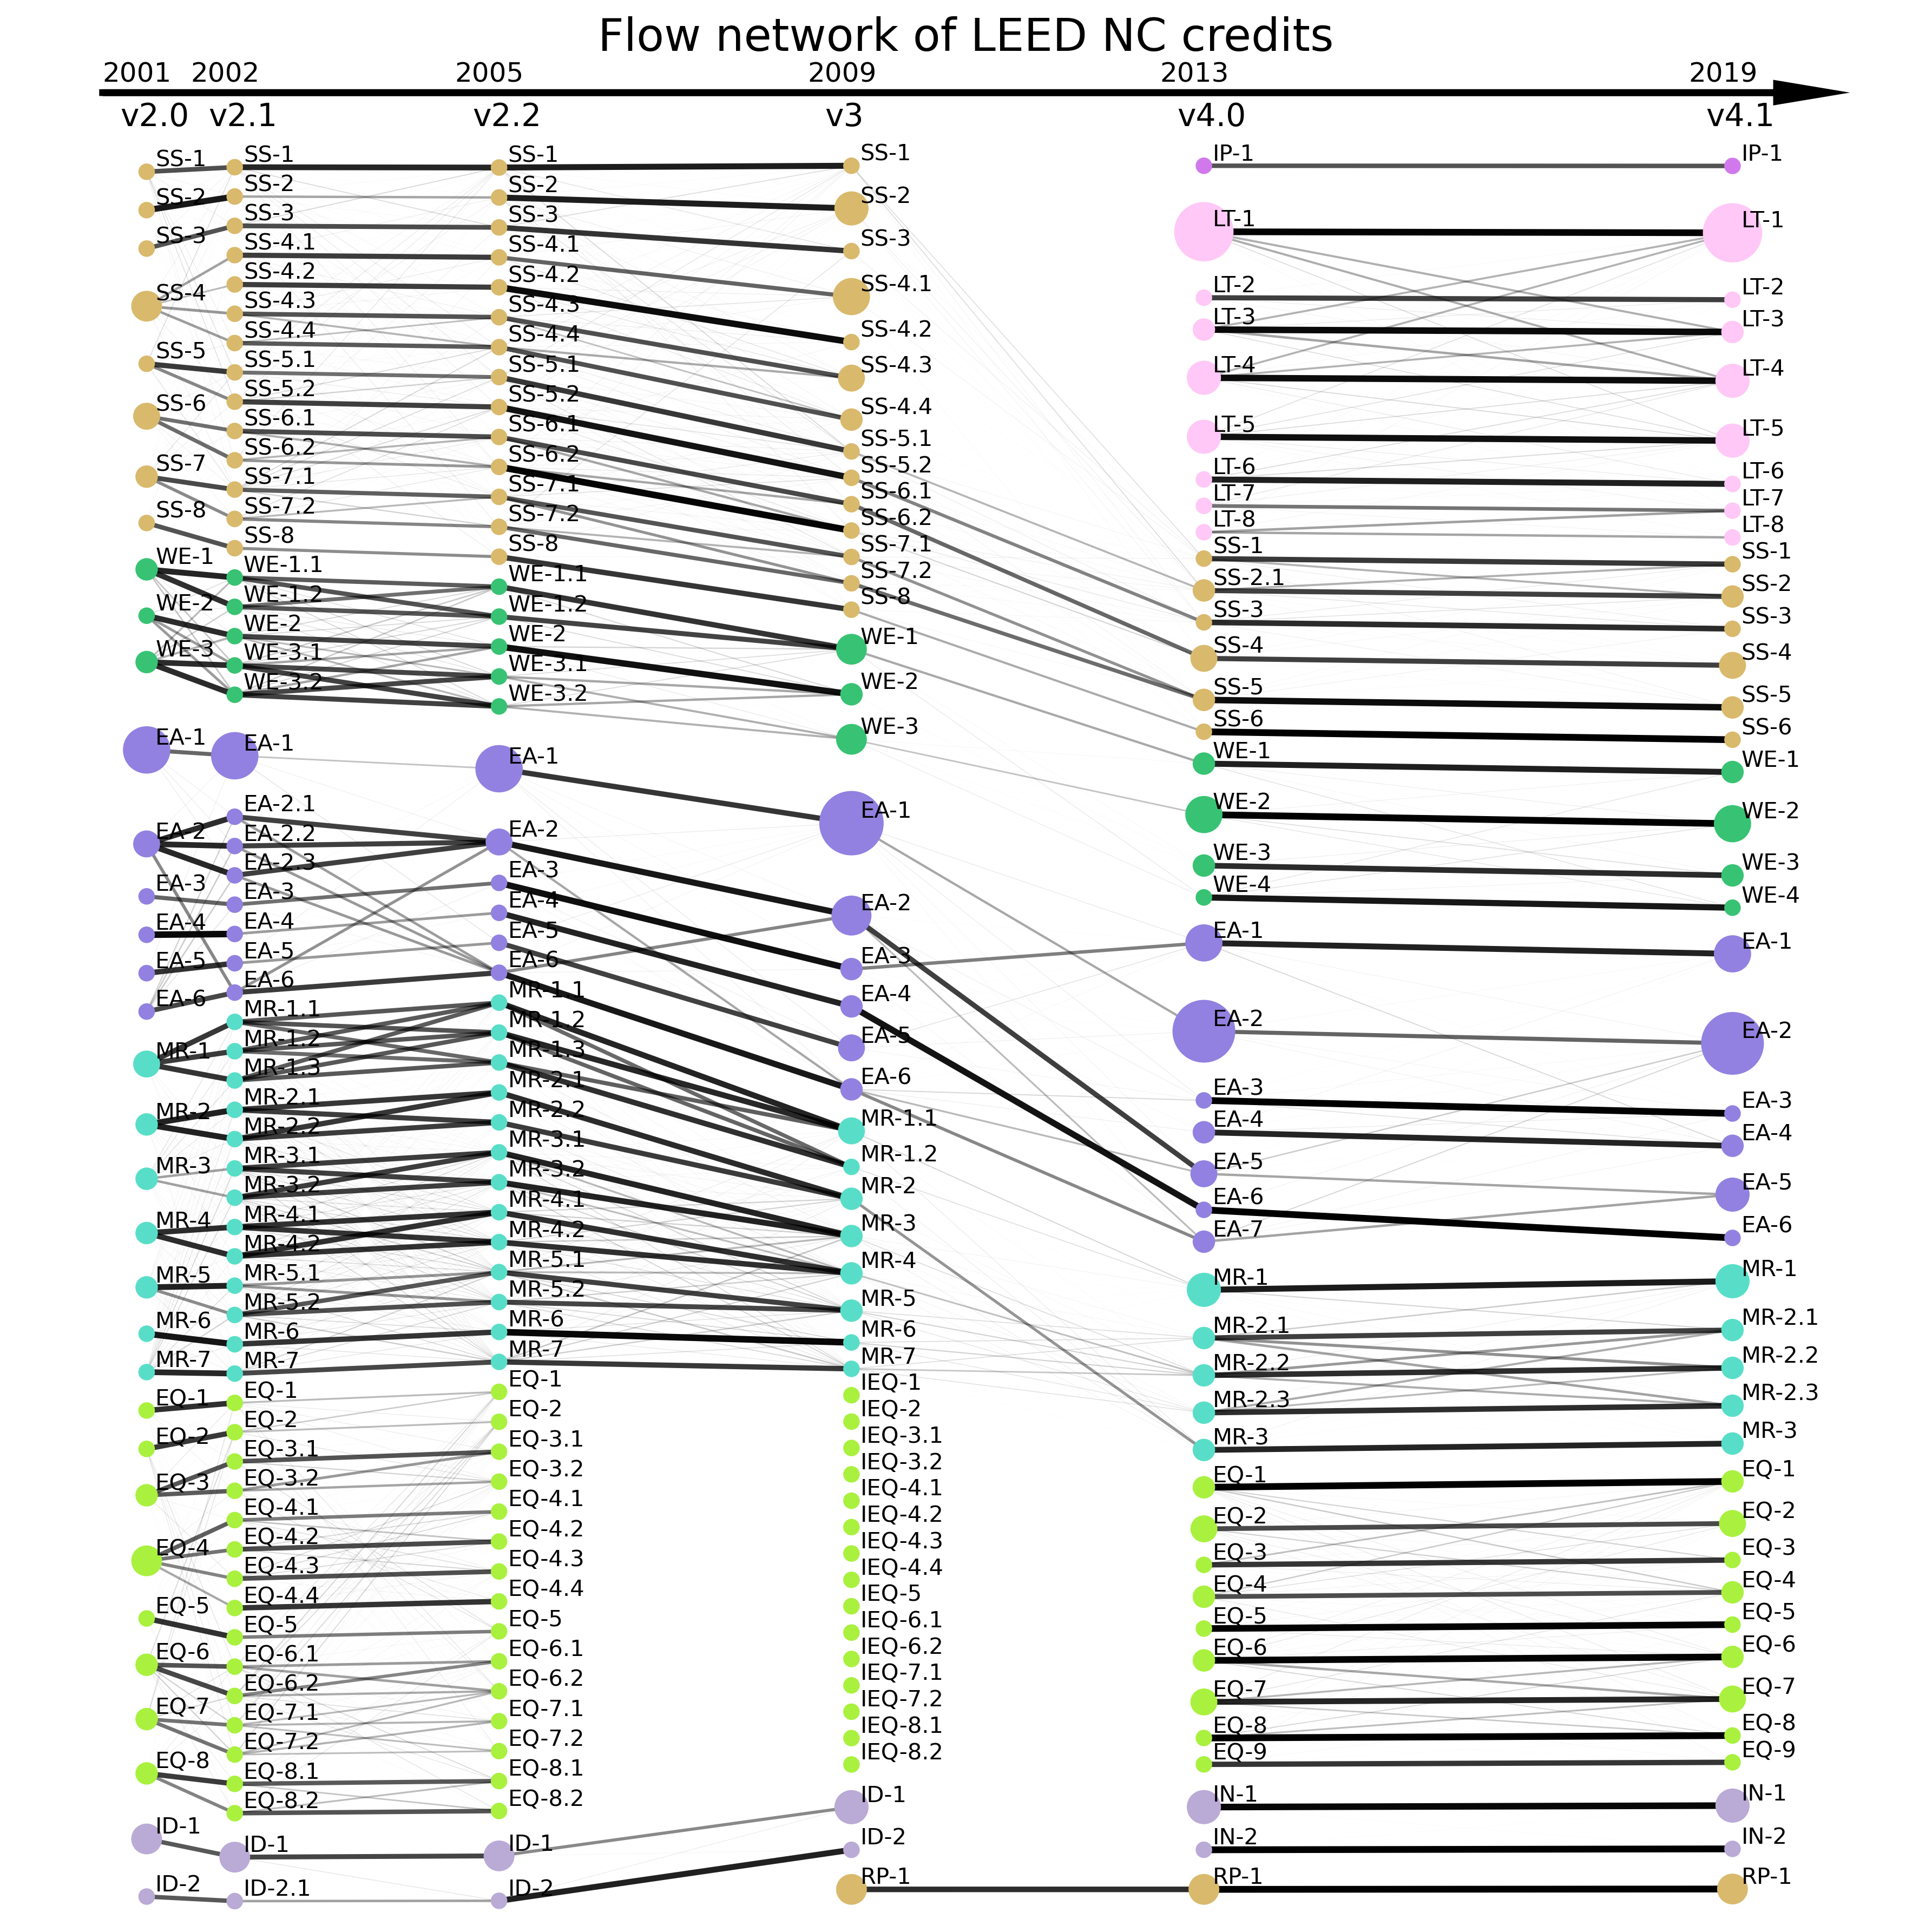

In [22]:
fig, ax = plt.subplots(figsize=(12, 12), dpi=300)

for i in range(6):
    f = df[i]
    X = [f['year']] * len(f['cred'])
    Y = get_Ypos(f['cred'])
    ax.scatter(
        X, Y,
        s=[40*s for s in f['cred']['Points'].to_list()],
        c=[get_color(cat) for cat in f['cred']['Category'].to_list()],
        zorder=1
    )
    for j in range(len(X)):
        ax.text(
            X[j]+0.1, Y[j]-0.3,
            f['cred']['ID'].tolist()[j],
            c='k', zorder=2
        )
    ax.text(f['year']-0.5, -4, str(f['year']), fontsize=12)
    ax.text(f['year']-0.3, -1.5, str(f['ver']), fontsize=14)

    

thresh = 0 #0.2
# ax.text(2000.5, -6, 'threshold='+str(thresh))
for i in range(5):
    f1, f2 = df[i], df[i+1]
    X1, X2 = [f1['year']] * len(f1['cred']), [f2['year']] * len(f2['cred'])

    Y1, Y2 = get_Ypos(f1['cred']), get_Ypos(f2['cred'])

    for j1 in range(len(X1)):
        for j2 in range(len(X2)):
            similarity = get_connection(f1, f2, j1, j2)
            if similarity<=thresh:
                continue
            elif similarity>=1:
                alpha=1
            else:
                alpha=(similarity-thresh)/(1-thresh)
            ax.plot(
                [X1[j1], X2[j2]], [Y1[j1], Y2[j2]],
                'k', linewidth=alpha*3, alpha=alpha,
                zorder=0
            )

ax.set_ylim(-5, 100)
ax.invert_yaxis()

ax.arrow(
    2000.5, -3.4, 19, 0,
    length_includes_head=False, head_width=1, head_length=0.6,
    fc='k', ec='k',
    linewidth=3
)

plt.axis('off')
plt.title('Flow network of LEED NC credits', fontsize=20)
plt.tight_layout()

plt.savefig('../Outputs/Flow_network.jpg')

plt.show()


In [23]:
a = [0] * 3037
b = [0] * 3037
ca, cb = 0, 0
for i in data.index:
    if data.loc[i, 'Version']=='v3' and data.loc[i, 'ID'][:2]=='SS' and pd.to_numeric(data.loc[i, 'ID'].split('-')[1])<5:
        for j in range(len(a)):
            a[j] += data.loc[i, 'TF_IDF'][j]
            ca += 1
    elif data.loc[i, 'Version']=='v4.0' and data.loc[i, 'ID'][:2]=='LT':
        for j in range(len(b)):
            b[j] += data.loc[i, 'TF_IDF'][j]
            cb += 1

for j in range(3037):
    a[j] = a[j]/ca
    b[j] = b[j]/cb

In [24]:
for i in range(3037):
    if a[i]>0.6*np.max(a):
        print(dictionary[i] + ' ' + str(a[i]))

facility 9.763513295279844e-06
land 1.1190495575820486e-05
park 1.1040396012823575e-05
parking 1.1177204655785806e-05
bicycle 1.3110752555673197e-05
rack 1.023503353297783e-05
secure 1.023503353297783e-05
station 1.2285647787686571e-05
vehicle 1.5493468628514367e-05
entrance 1.3089749666355566e-05
residential 1.3215223248955278e-05
yard 1.080240799012783e-05
fte 1.470140507108628e-05
case 1.4363358738660507e-05


In [25]:
for i in range(3037):
    if b[i]>0.4*np.max(b):
        print(dictionary[i] + ' ' + str(b[i]))

parking 1.5644108191019255e-05
density 9.791619359315362e-06
bicycle 1.3217412861846675e-05
transit 1.0888082048289566e-05
vehicle 1.6370137859687635e-05
shell 1.2622202871675907e-05
storage 1.2033492660785678e-05
distance 9.562463762965446e-06
core 1.2964525756633474e-05
bd 1.8609957455704083e-05
core_shell 1.365189829633238e-05
point_bd 1.909519162595989e-05
route 8.01799311596344e-06
trip 8.01799311596344e-06
